# NLP Crash Course - Part 2: Topic Modeling
Prepared by: Nickolas Freeman, PhD

In this notebook, we will look at how we can use the tokenized tweets we prepared in the *Part 1* notebook to construct topic models. From https://en.wikipedia.org/wiki/Natural_language_processing:
> In machine learning and natural language processing, a topic model is a type of statistical model for discovering the abstract "topics" that occur in a collection of documents. Topic modeling is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. Intuitively, given that a document is about a particular topic, one would expect particular words to appear in the document more or less frequently: "dog" and "bone" will appear more often in documents about dogs, "cat" and "meow" will appear in documents about cats, and "the" and "is" will appear approximately equally in both. A document typically concerns multiple topics in different proportions; thus, in a document that is 10% about cats and 90% about dogs, there would probably be about 9 times more dog words than cat words. The "topics" produced by topic modeling techniques are clusters of similar words. A topic model captures this intuition in a mathematical framework, which allows examining a set of documents and discovering, based on the statistics of the words in each, what the topics might be and what each document's balance of topics is.

We will use the `gensim` library for our topic modeling analysis. More information about Gensim can be found at the project's website (https://radimrehurek.com/gensim/).

The following code block imports the libraries we will use.

In [1]:
# Libraries that are part of the Python standard library
import gzip
import itertools
import json
import pathlib
import time

# Third-party packages
from ipywidgets import interact
import gensim
import matplotlib.pyplot as plt
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels.api as sm
import statsmodels.formula.api as smf

Natural language processing has received a lot of attention in recent years. This attention has resulted in several techniques being developed for detecting the sentiment of texts (senitment analysis), identifying core topics in text (topic modeling), predicting the author of texts (author attribution), translation, and generating text (generative models). The field is very broad and evolving rapidly. In this notebook, we will look at a popular technique for topic modeling, *Latent Dirichlet Allocation*. The purpose of this notebook is not to be a comprehensive reference for the technique, but instead it is intended to give you an example of how you may go about exploring a new model that you are considering for an analysis.

## Latent Dirichlet Distribution (LDA) Overview
The Latent Dirichlet Allocation was introduced in the paper:
> Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.

At the time of writing (8/31/2020), Google Scholar reports over 30,000 citations for the paper. Before we dive into the technique, let's look at the definitions for the terms that make up its name.

The term *latent* is defined as:
- [adjective] (of a quality or state) existing but not yet developed or manifest; hidden or concealed.

From https://en.wikipedia.org/wiki/Dirichlet_process:
> In probability theory, Dirichlet processes (after Peter Gustav Lejeune Dirichlet) are a family of stochastic processes whose realizations are probability distributions. In other words, a Dirichlet process is a probability distribution whose range is itself a set of probability distributions.
The term latent is defined as:

The term *allocation* is defined as:
- [noun] the action or process of allocating or distributing something.


**The core assumption of LDA is that documents are a collection of words that are associated with topics. However, when we see a document, we don't necessarily get topic labels. Instead, we have collections of words that are indicitive of a topic. The goal of the method is to determine the *latent* topics that are associated with words. A key thing to note is that a single word may be associated with different topics, e.g., we may use the word course to refer to a compnent of an educational curriculum or a sequence of road segments traversed during a race. LDA utilizes dirichlet distributions to learn the distributions of words that are related to a topic.** The following image illustrates the assumption of latent topics in LDA (image originally copied from https://miro.medium.com/max/2504/1*LsTAeih16RXl4VSZO_Hhag.png).
<img src="lda_ex_images/latent_topics.png" alt="Drawing" style="width: 800px; height: 300px"/>

The following figure (image originally copied from https://thatware.co/topic-modelling/) provides a high-level overview of the LDA model proposed by Blei, Ng, and Jordan. As is true for many models that you will encounter, the underlying model is based on sophisticated mathematical and statistical ideas. Sometimes it is necessary to understand all of these details. However, many such techniques are implemented in commercial and open-source products. To use these implementations, you do need to have an overall idea of what the method aims to achieve and the parameters that influence the method, but it will not be possible for you to understand every approach in great depth.
<img src="lda_ex_images/lda_model.png" alt="Drawing" style="width: 800px; height: 400px"/>

(image from https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

As an example, one of the influential parameters for LDA is the $\alpha$ parameter, which controls the dirichlet process dictating the expected number of topics in a document. This parameter is actually a $K$-dimensional vector, where $K$ is the number of topics. The following image (image originally copied from https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158) shows how dirichlet distribution changes as a function of $\alpha$. In LDA, each *point* in the support of the distribution would represent a topic.
<img src="lda_ex_images/dirichlet_distributions.png" alt="Drawing" style="width: 600px; height: 400px"/>

The following cell links to a YouTube video that provides a good overview of the LDA *machine*.

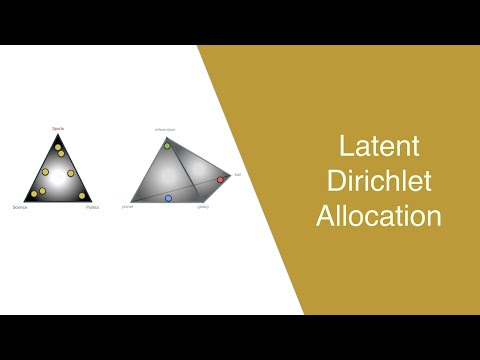

In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo('T05t-SqKArY', width=600, height=400)

The following code block defines a simple helper function that we will use to print status messages.

In [3]:
def print_status(message, start_timestamp, width = 60):
    
    elapsed_time = round(time.time() - start_timestamp, 2)
    print(f'{message} (elapsed time: {elapsed_time} seconds)')
    print('-'*width)

The following code block reads the tweet tokens that we processed in the *Part 1* notebook. The data we prepared included the tokens for 50,000 tweets. To speed up our initial demonstrations, we will only keep 5,000 tweets.

In [4]:
# create a pathlib.Path object for the data
texts_path = pathlib.Path('processed_tokens.json.gz')

# open the data filepath
with gzip.GzipFile(texts_path, 'r') as fp:
    
    # read the bytes from the datafile
    json_bytes = fp.read()
    
    # decode the bytes to utf-8
    json_str = json_bytes.decode('utf-8')
    
    # load the decoded bytes as JSON
    texts = json.loads(json_str)
    
texts = texts[:5000]
    
print(f'The data includes {len(texts)} observations.')

The data includes 5000 observations.


LDA, and most other algorithms you will encounter, work with numeric data. Thus, we need to a numerical representation for our tweet tokens. We will use a *bag-of-words (BOW)* representation. From https://en.wikipedia.org/wiki/Bag-of-words_model:
>The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity. The bag-of-words model has also been used for computer vision.
>
>The bag-of-words model is commonly used in methods of document classification where the (frequency of) occurrence of each word is used as a feature for training a classifier.
>
>An early reference to "bag of words" in a linguistic context can be found in Zellig Harris's 1954 article on Distributional Structure.

The first step in this process is assigning a unique integer ID to each token in our corpus. The following code block shows how this can be achieved using `gensim`.

In [5]:
id2word = gensim.corpora.Dictionary(texts)

The following code block shows how we can use the created `id2word` object to see the representation for a particular tweet.

In [6]:
current_tweet = 300
print(f'Our tweet tokens are:')
print(texts[current_tweet], '\n')

for word in texts[current_tweet]:
    word_id = id2word.token2id[word]
    num_documents = id2word.dfs[word_id]
    print(f'Word "{word}" is saved as {word_id} and occurs in {num_documents} document(s).')
    
print(f'\nIn total, the id2word mapping accounts for {len(id2word.token2id)} tokens.')

Our tweet tokens are:
['@peterpsquar', 'bro', 'send', 'sinc', 'two_day', 'im', 'stuck', 'school_run', 'cash_food', 'hope', 'im', 'lucki', 'today_god', 'continu_bless', '🙏_🙏', '🙏_🙏', '🙏_🙏', 'emeka', 'ugwunnaaccess', 'diamond', '00843395', '87'] 

Word "@peterpsquar" is saved as 3972 and occurs in 1 document(s).
Word "bro" is saved as 2074 and occurs in 16 document(s).
Word "send" is saved as 463 and occurs in 27 document(s).
Word "sinc" is saved as 1011 and occurs in 45 document(s).
Word "two_day" is saved as 3980 and occurs in 3 document(s).
Word "im" is saved as 1342 and occurs in 14 document(s).
Word "stuck" is saved as 3978 and occurs in 6 document(s).
Word "school_run" is saved as 3977 and occurs in 1 document(s).
Word "cash_food" is saved as 3973 and occurs in 1 document(s).
Word "hope" is saved as 2018 and occurs in 58 document(s).
Word "im" is saved as 1342 and occurs in 14 document(s).
Word "lucki" is saved as 3403 and occurs in 9 document(s).
Word "today_god" is saved as 3979 

The LDA technique is essentially an unsupervised machine learning technique that clusters words into groups (topics) and iteratively goes through the corpus improving word-to-group assignments. The algorithm may struggle to classify words that appear too frequently. Thus, `gensim` includes a `filter_extremes` method that we can use to restrict the words that are considered.

In [7]:
id2word.filter_extremes(no_below = 2, 
                        no_above = 0.1)

print(f'After filtering, the id2word mapping accounts for {len(id2word.token2id)} tokens.')

After filtering, the id2word mapping accounts for 9411 tokens.


The following code block prints our example again after filtering the extreme values.

In [8]:
print(f'Our tweet tokens are:')
print(texts[current_tweet], '\n')

for word in texts[current_tweet]:
    if word in id2word.token2id:
        word_id = id2word.token2id[word]
        num_documents = id2word.dfs[word_id]
        print(f'Word "{word}" is saved as {word_id} and occurs in {num_documents} documents.')
    else:
        print(f'"{word}" is not in id2word object.')
    
print(f'\nIn total, the id2word mapping accounts for {len(id2word.token2id)} tokens.')

Our tweet tokens are:
['@peterpsquar', 'bro', 'send', 'sinc', 'two_day', 'im', 'stuck', 'school_run', 'cash_food', 'hope', 'im', 'lucki', 'today_god', 'continu_bless', '🙏_🙏', '🙏_🙏', '🙏_🙏', 'emeka', 'ugwunnaaccess', 'diamond', '00843395', '87'] 

"@peterpsquar" is not in id2word object.
Word "bro" is saved as 1331 and occurs in 16 documents.
Word "send" is saved as 337 and occurs in 27 documents.
Word "sinc" is saved as 689 and occurs in 45 documents.
Word "two_day" is saved as 2345 and occurs in 3 documents.
Word "im" is saved as 894 and occurs in 14 documents.
Word "stuck" is saved as 2344 and occurs in 6 documents.
"school_run" is not in id2word object.
"cash_food" is not in id2word object.
Word "hope" is saved as 1291 and occurs in 58 documents.
Word "im" is saved as 894 and occurs in 14 documents.
Word "lucki" is saved as 2077 and occurs in 9 documents.
"today_god" is not in id2word object.
"continu_bless" is not in id2word object.
Word "🙏_🙏" is saved as 2346 and occurs in 7 docume

We can use the `doc2bow` method of our `id2word` object to get a numerical (BOW) representation for our corpus of tweets.

In [9]:
corpus = [id2word.doc2bow(text) for text in texts]
corpus[current_tweet]

[(337, 1),
 (689, 1),
 (894, 2),
 (1291, 1),
 (1331, 1),
 (2077, 1),
 (2342, 1),
 (2343, 1),
 (2344, 1),
 (2345, 1),
 (2346, 3)]

Using our `id2word` and `corpus` objects, it is simple to use `gensim`'s default LDA implementation

In [10]:
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus = corpus,
                                                    id2word = id2word,
                                                    random_state = 0)

We can get a sense of the quality of the model by looking at it's *coherence*. There are several coherence measures implemented in `gensim`. By default, `gensim` uses the $c_{v}$ coherences model. Although there are many more details, the $c_{v}$ measure essentially looks at the words that are grouped together in a topic and computes the probability of these words co-occuring given the provided corpus and texts. **Could we do better here?**

In [11]:
cm = gensim.models.coherencemodel.CoherenceModel(model = lda_model, corpus = corpus, texts = texts)
coherence_score = cm.get_coherence()
print(f'Coherence is {coherence_score}')

Coherence is 0.5970828533291048


The following code block uses the `pyLDAvis` library to generate an interavtive visualization for our topic model.

In [12]:
pyLDAvis_model = pyLDAvis.gensim.prepare(lda_model, 
                                         corpus, 
                                         id2word, 
                                         sort_topics=False) 

pyLDAvis.save_html(pyLDAvis_model,
                   'example_vis.html')

The following code block changes some of the default parameters to determine a different model.

In [13]:
start_time = time.time()

print_status('Fitting LDA model', start_time)
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus = corpus,
                                                    id2word = id2word,
                                                    num_topics = 20,
                                                    alpha = 'asymmetric',
                                                    passes = 30,
                                                    random_state = 0)

print_status('Getting coherence', start_time)
cm = gensim.models.coherencemodel.CoherenceModel(model = lda_model, corpus = corpus, texts = texts)
coherence_score = cm.get_coherence()
print_status(f'Coherence = {coherence_score}', start_time)

print_status(f'Preparing pyLDAvis_model', start_time)
pyLDAvis_model = pyLDAvis.gensim.prepare(lda_model, 
                                         corpus, 
                                         id2word, 
                                         sort_topics=False) 

print_status(f'Saving pyLDAvis visualization', start_time)
pyLDAvis.save_html(pyLDAvis_model,
                   'example_vis2.html')

Fitting LDA model (elapsed time: 0.0 seconds)
------------------------------------------------------------
Getting coherence (elapsed time: 28.26 seconds)
------------------------------------------------------------
Coherence = 0.4912077859784992 (elapsed time: 38.72 seconds)
------------------------------------------------------------
Preparing pyLDAvis_model (elapsed time: 38.72 seconds)
------------------------------------------------------------
Saving pyLDAvis visualization (elapsed time: 45.87 seconds)
------------------------------------------------------------


We can get the topics associated with a particular text by passing our BOW representation of the tweet to `get_document_topics` method of out `lda_model` object.

In [14]:
lda_model.get_document_topics(corpus[300])

[(12, 0.93556577)]

In [15]:
lda_model.get_document_topics(corpus[200])

[(0, 0.015590419), (1, 0.887626), (2, 0.010768962)]

## Parameter Experiment

The two topic models that we have fit so far were not all that informative. A primary reason for this is that we did not use a very large number of tweets as a corpus. In general, the more data you provide, the better your results can be. However, as you increase the size of your corpus, the computational time reguired to execute the LDA algorithm also increases and it becomes more difficult to perform ad-hoc parameter tuning. In such cases, it makes sense to design an experiment. The following code block shows how we can define an experimtal design that will allow us to observe the changes in multiple parameters. **Note that in this experiment, I am using two different data files that have been prepared using different data preparation pipelines. Both data files are based on 100,000 tweets. They were generated using the last code block in the *Part 1* notebook.**

In [16]:
experimental_design_spec = {
    'data_files': [pathlib.Path('data', 'mwe_lemmas_stems_nopunct_nostopw_bigram_trigram.json.gz'),
                   pathlib.Path('data', 'base.json.gz')],
    'topics': [10, 30],
    'alpha': ['symmetric', 'asymmetric', 0.001, 0.01],
    'eta': ['auto', 0.001, 0.01],
    'iterations': [50, 100],
    'passes': [1, 10],     
    'decay': [0.5, 0.99],
}

experimental_design_settings = list(itertools.product(
    experimental_design_spec['data_files'],
    experimental_design_spec['topics'], 
    experimental_design_spec['alpha'], 
    experimental_design_spec['eta'],
    experimental_design_spec['iterations'],
    experimental_design_spec['passes'],
    experimental_design_spec['decay'],
))

column_names = [
    'data_filepath',
    'topics',
    'alpha',
    'eta',
    'iterations',
    'passes',
    'decay',
]

experimental_design = pd.DataFrame(experimental_design_settings, 
                                   columns = column_names)

experimental_design.head()

,data_filepath,topics,alpha,eta,iterations,passes,decay
0,data\mwe_lemmas_stems_nopunct_nostopw_bigram_t...,10,symmetric,auto,50,1,0.50
1,data\mwe_lemmas_stems_nopunct_nostopw_bigram_t...,10,symmetric,auto,50,1,0.99
2,data\mwe_lemmas_stems_nopunct_nostopw_bigram_t...,10,symmetric,auto,50,10,0.50
3,data\mwe_lemmas_stems_nopunct_nostopw_bigram_t...,10,symmetric,auto,50,10,0.99
4,data\mwe_lemmas_stems_nopunct_nostopw_bigram_t...,10,symmetric,auto,100,1,0.50


For the sake of time, I pre-ran the experiment using the following code block. To run the experiment, you can set the value of the `run_experiment` variable to `True`. **I do not advice attempting to run the experiment. It will take a very long time!**

In [17]:
run_experiment = False

if run_experiment:
    start_time = time.time()
    
    print_status('Defining experimental design', start_time)
    
    experimental_design_spec = {
        'data_files': [pathlib.Path('data', 'mwe_lemmas_stems_nopunct_nostopw_bigram_trigram.json.gz'),
                       pathlib.Path('data', 'base.json.gz')],
        'topics': [10, 30],
        'alpha': ['symmetric', 'asymmetric', 0.001, 0.01],
        'eta': ['auto', 0.001, 0.01],
        'iterations': [50, 100],
        'passes': [1, 10],     
        'decay': [0.5, 0.99],
    }

    experimental_design_settings = list(itertools.product(
        experimental_design_spec['data_files'],
        experimental_design_spec['topics'], 
        experimental_design_spec['alpha'], 
        experimental_design_spec['eta'],
        experimental_design_spec['iterations'],
        experimental_design_spec['passes'],
        experimental_design_spec['decay'],
    ))

    column_names = [
        'data_filepath',
        'topics',
        'alpha',
        'eta',
        'iterations',
        'passes',
        'decay',
    ]

    experimental_design = pd.DataFrame(experimental_design_settings, 
                                       columns = column_names)

    experimental_design = experimental_design.to_dict(orient = 'index')

    print_status('Checking for directories', start_time)
    necessary_directories = ['vis_files']
    for directory in necessary_directories:
        if not pathlib.Path(directory).exists():
            pathlib.Path(directory).mkdir()

    for current_experiment_index, current_experiment in experimental_design.items():

        texts_path = pathlib.Path(current_experiment['data_filepath'])
        if texts_path.exists():

            with gzip.GzipFile(texts_path, 'r') as fp:
                json_bytes = fp.read()
                json_str = json_bytes.decode('utf-8')
                texts = json.loads(json_str)

            no_below_val = 2
            no_above_proportion = 0.20

            instance_string = f'exp_{current_experiment_index}'
            print_status(f'Starting experiment {instance_string}', start_time)
            id2word = gensim.corpora.Dictionary(texts)
            id2word.filter_extremes(no_below = no_below_val, 
                                    no_above = no_above_proportion)
            corpus = [id2word.doc2bow(text) for text in texts]

            print_status(f'Defining filepaths', start_time)

            vis_file_path =  pathlib.Path('vis_files', f'{instance_string}.html')

            print_status(f'Running LDA', start_time)
            lda_model = gensim.models.ldamulticore.LdaMulticore(corpus = corpus,
                                                                workers = 3,
                                                                id2word = id2word,
                                                                num_topics = current_experiment['topics'],
                                                                passes = current_experiment['passes'],
                                                                alpha = current_experiment['alpha'],
                                                                eta = current_experiment['eta'],
                                                                decay = current_experiment['decay'],
                                                                iterations = current_experiment['iterations'],
                                                                random_state = 0)

            print_status(f'Creating pyLDAvis model', start_time)
            pyLDAvis_model = pyLDAvis.gensim.prepare(lda_model, 
                                                     corpus, 
                                                     id2word, 
                                                     sort_topics=False) 

            print_status(f'Creating pyLDAvis vizualization', start_time)
            pyLDAvis.save_html(pyLDAvis_model,
                               vis_file_path.__str__())

            print_status(f'Computing coherence', start_time)
            cm = gensim.models.coherencemodel.CoherenceModel(model = lda_model, corpus = corpus, texts = texts)
            coherence_score = cm.get_coherence()
            print_status(f'Coherence is {coherence_score}', start_time)
            experimental_design[current_experiment_index]['coherence'] = coherence_score

            pd.DataFrame().from_dict(experimental_design, orient = 'index').to_csv('experimental_results.csv')

The following code block reads in a file containing the coherence results for the experiments.

In [18]:
coherence_data = pd.read_csv('experimental_results.csv')
coherence_data = coherence_data.rename(columns = {'Unnamed: 0': 'ID'})
coherence_data['ID'] = 'exp_' + coherence_data['ID'].astype(str)
filepath_map = {
    'data\\mwe_lemmas_stems_nopunct_nostopw_bigram_trigram.json.gz': 'Extensive',
    'data\\base.json.gz': 'Basic',
}
coherence_data['preprocessing'] = coherence_data['data_filepath'].map(filepath_map)
coherence_data.head()

,ID,data_filepath,topics,alpha,eta,iterations,passes,decay,coherence,preprocessing
0,exp_0,data\mwe_lemmas_stems_nopunct_nostopw_bigram_t...,10,symmetric,auto,50,1,0.50,0.107135,Extensive
1,exp_1,data\mwe_lemmas_stems_nopunct_nostopw_bigram_t...,10,symmetric,auto,50,1,0.99,0.076528,Extensive
2,exp_2,data\mwe_lemmas_stems_nopunct_nostopw_bigram_t...,10,symmetric,auto,50,10,0.50,0.266149,Extensive
3,exp_3,data\mwe_lemmas_stems_nopunct_nostopw_bigram_t...,10,symmetric,auto,50,10,0.99,0.120214,Extensive
4,exp_4,data\mwe_lemmas_stems_nopunct_nostopw_bigram_t...,10,symmetric,auto,100,1,0.50,0.097826,Extensive


We can use regression to identify the high-level effects of each of the experimental design parameters. The following code block defines a regression formula that we will use to conduct such a regression using the `statsmodels` library.

In [19]:
parameter_columns = [
    'topics', 
    'alpha', 
    'eta', 
    'iterations', 
    'passes',
    'decay',  
    'preprocessing',
]

metric_column = 'coherence'
regression_formula = f'{metric_column} ~ '
regression_formula += ' + '.join(parameter_columns)
regression_formula

'coherence ~ topics + alpha + eta + iterations + passes + decay + preprocessing'

The following code block runs the regression. The regression results suggest that using an *asymmetric* alpha, a higher number of topics, a higher number of passes, and a lower decay can improve the model coherence.

In [20]:
mod = smf.ols(formula = regression_formula, data = coherence_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              coherence   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     252.0
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          3.83e-159
Time:                        11:22:50   Log-Likelihood:                 686.72
No. Observations:                 384   AIC:                            -1351.
Df Residuals:                     373   BIC:                            -1308.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

The following code block defines a plotting function that we can use to visually inspect the effects of two parameters simultaneously.

In [21]:
def plot_interaction(primary_parameter = 'topics',
                     hue_parameter = 'alpha',
                    ):

    fig, ax = plt.subplots(1, 1, figsize = (6, 4))
    sns.pointplot(
        x = primary_parameter,
        y = 'coherence',
        hue = hue_parameter,
        dodge = 0.2,
        data = coherence_data,
    )
    ax.set_xlabel(primary_parameter.title(), fontsize = 12)
    ax.set_ylabel('Coherence', fontsize = 12)

    plt.show()

The following code block uses the `plot_interaction` function to define an interactive plot.

In [22]:
interact(plot_interaction, 
         primary_parameter = parameter_columns,
         hue_parameter = parameter_columns
        );

interactive(children=(Dropdown(description='primary_parameter', options=('topics', 'alpha', 'eta', 'iterations…

The following code block retrieves all parameter settings for the details for the best model and saves them in a dictionary called `best_params`.

In [23]:
best_coherence_index = coherence_data['coherence'].idxmax()
best_params = coherence_data.loc[best_coherence_index, :].to_dict()
best_params

{'ID': 'exp_126',
 'data_filepath': 'data\\mwe_lemmas_stems_nopunct_nostopw_bigram_trigram.json.gz',
 'topics': 30,
 'alpha': 'asymmetric',
 'eta': 'auto',
 'iterations': 100,
 'passes': 10,
 'decay': 0.5,
 'coherence': 0.4403135873542826,
 'preprocessing': 'Extensive'}

The following code block allows you to run the LDA process for the best parameter setting by setting the value of the `run_best_params` variable to `True`. The model is saved to a file named `best_model.model` in the `model_files` sub-folder.

In [24]:
run_best_params = False

if run_best_params:
    with gzip.GzipFile(best_params['data_filepath'], 'r') as fp:
        json_bytes = fp.read()
        json_str = json_bytes.decode('utf-8')
        texts = json.loads(json_str)

    no_below_val = 2
    no_above_proportion = 0.20

    id2word = gensim.corpora.Dictionary(texts)
    id2word.filter_extremes(no_below = no_below_val, 
                            no_above = no_above_proportion)
    corpus = [id2word.doc2bow(text) for text in texts]

    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus = corpus,
                                                        workers = 3,
                                                        id2word = id2word,
                                                        num_topics = best_params['topics'],
                                                        passes = best_params['passes'],
                                                        alpha = best_params['alpha'],
                                                        eta = best_params['eta'],
                                                        decay = best_params['decay'],
                                                        iterations = best_params['iterations'],
                                                        random_state = 0)
    
    model_path = pathlib.Path('model_files', 'best_model.model')
    lda_model.save(model_path.__str__())

The following code block shows how we can load and use a saved model.

In [25]:
with gzip.GzipFile(best_params['data_filepath'], 'r') as fp:
    json_bytes = fp.read()
    json_str = json_bytes.decode('utf-8')
    texts = json.loads(json_str)
    
no_below_val = 2
no_above_proportion = 0.20

id2word = gensim.corpora.Dictionary(texts)
id2word.filter_extremes(no_below = no_below_val, 
                        no_above = no_above_proportion)
corpus = [id2word.doc2bow(text) for text in texts]

model_path = pathlib.Path('model_files', 'best_model.model')
lda_model = gensim.models.LdaModel.load(model_path.__str__())

lda_model.get_document_topics(corpus[300])

[(5, 0.9010063), (9, 0.05316979)]